# create a model
* create a pretrained model
* train the model with new data
* save the trained model

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

print(f"torch {torch.__version__}, torchvision {torchvision.__version__}")

torch 2.0.1+cu118, torchvision 0.15.2+cu118


In [2]:
# import torchinfo
try:
    from torchinfo import summary
except:
    print(f"[INFO] installing torchinfo...")
    !pip install torchinfo
    from torchinfo import summary

In [3]:
# import modules from sources
from sources import utils, datasetup, engine, models

2023-11-08 22:49:12.921364: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 22:49:12.963357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 22:49:13.607839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# download data
source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"

image_path_20 = datasetup.download_data(
    source=source,
    destination="image_20"
)

[INFO] creating data/image_20...
[INFO] downloading pizza_steak_sushi_20_percent.zip to data...
[INFO] extracting pizza_steak_sushi_20_percent.zip to data/image_20...
[INFO] removing pizza_steak_sushi_20_percent.zip...


In [6]:
# setup train and test directory
train_dir = image_path_20 / "train"
test_dir = image_path_20 / "test"

In [7]:
# get a pretrained efficientnetb2 model
model, model_transforms = models.create_effnet(effnet_version=2)

[INFO] creating EfficientNet_B2...


In [8]:
# create dataloaders
train_dataloader, test_dataloader, class_names = datasetup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transforms=model_transforms,
    test_transforms=model_transforms,
    batch_size=32
)

[INFO] creating dataloaders... 
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f65ad57ff10> 
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f655bda6090> 
number of class_names: 3


In [9]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [10]:
# do training
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 | train_loss: 0.9935 | train_acc: 0.5250 | test_loss: 0.7496 | test_acc: 0.8892
epoch: 1 | train_loss: 0.7029 | train_acc: 0.8396 | test_loss: 0.6028 | test_acc: 0.9443
epoch: 2 | train_loss: 0.5898 | train_acc: 0.8375 | test_loss: 0.4875 | test_acc: 0.9318
epoch: 3 | train_loss: 0.5411 | train_acc: 0.8646 | test_loss: 0.4563 | test_acc: 0.9534
epoch: 4 | train_loss: 0.4415 | train_acc: 0.9042 | test_loss: 0.3983 | test_acc: 0.9352
epoch: 5 | train_loss: 0.3746 | train_acc: 0.9187 | test_loss: 0.3682 | test_acc: 0.9381
epoch: 6 | train_loss: 0.3633 | train_acc: 0.9187 | test_loss: 0.3476 | test_acc: 0.9381
epoch: 7 | train_loss: 0.3951 | train_acc: 0.9062 | test_loss: 0.3136 | test_acc: 0.9443
epoch: 8 | train_loss: 0.3720 | train_acc: 0.8958 | test_loss: 0.3204 | test_acc: 0.9506
epoch: 9 | train_loss: 0.2878 | train_acc: 0.9437 | test_loss: 0.2953 | test_acc: 0.9415
epoch: 10 | train_loss: 0.3056 | train_acc: 0.8979 | test_loss: 0.2730 | test_acc: 0.9443
epoch: 11 | train_lo

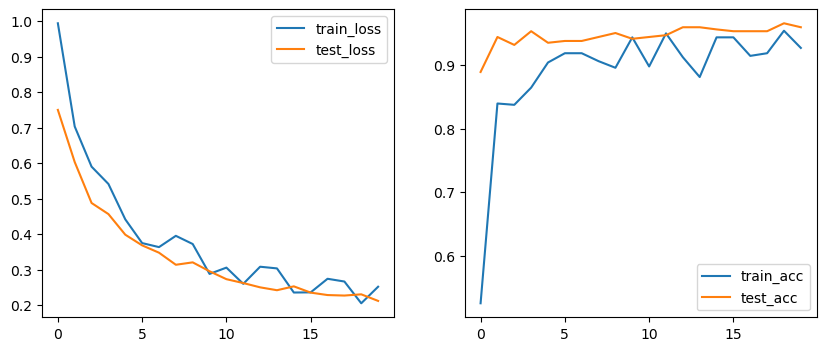

In [11]:
# visualize train and test loss and accuracy
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(results["train_loss"], label="train_loss")
ax[0].plot(results["test_loss"], label="test_loss")
ax[0].legend()

ax[1].plot(results["train_acc"], label="train_acc")
ax[1].plot(results["test_acc"], label="test_acc")
ax[1].legend()


In [12]:
# save trained model
saved_model_path = utils.save_model(
    model=model,
    model_dir="models",
    model_name_grid=[model.name]
)